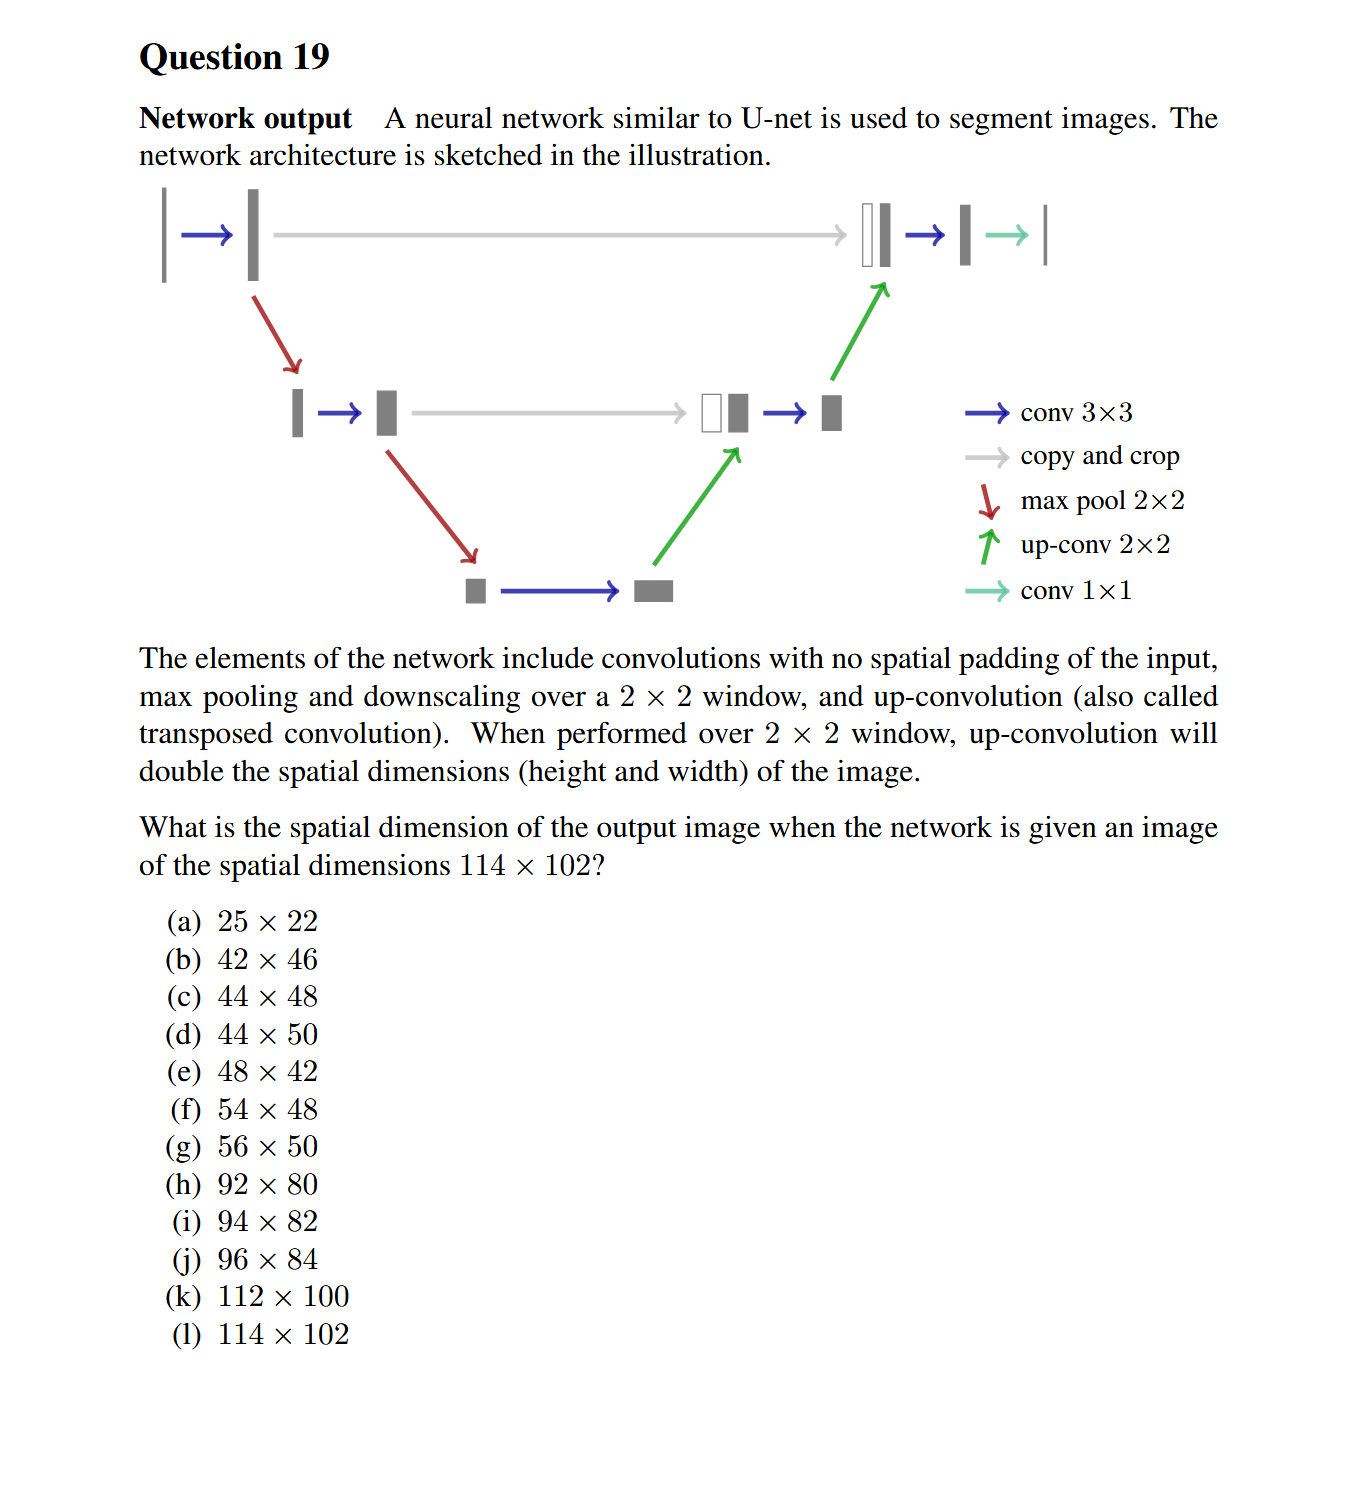

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetLike(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetLike, self).__init__()
        
        # Contracting path (encoder)
        # First level
        self.conv1_1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottom level
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        
        # Expansive path (decoder)
        # Second level
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(256, 128, kernel_size=3, padding=0)  # 256 because of concatenation
        
        # First level
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        # Fixed to accept 128 input channels (64+64 from concat)
        self.conv5_1 = nn.Conv2d(128, 64, kernel_size=3, padding=0)  # Changed from 256 to 128
        
        # Output layer
        self.conv_out = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x, print_dims=False):
        if print_dims:
            print(f"Input: {x.shape} -> spatial dimensions: {x.shape[2]} x {x.shape[3]}")
        
        # Contracting path
        # First level
        conv1 = F.relu(self.conv1_1(x))
        if print_dims:
            print(f"After conv1_1: {conv1.shape} -> spatial dimensions: {conv1.shape[2]} x {conv1.shape[3]}")
        
        # Store conv1 for skip connection
        pool1 = self.pool1(conv1)
        if print_dims:
            print(f"After pool1: {pool1.shape} -> spatial dimensions: {pool1.shape[2]} x {pool1.shape[3]}")
        
        # Second level
        conv2 = F.relu(self.conv2_1(pool1))
        if print_dims:
            print(f"After conv2_1: {conv2.shape} -> spatial dimensions: {conv2.shape[2]} x {conv2.shape[3]}")
        
        # Store conv2 for skip connection
        pool2 = self.pool2(conv2)
        if print_dims:
            print(f"After pool2: {pool2.shape} -> spatial dimensions: {pool2.shape[2]} x {pool2.shape[3]}")
        
        # Bottom level
        conv3 = F.relu(self.conv3_1(pool2))
        if print_dims:
            print(f"After conv3_1 (bottom): {conv3.shape} -> spatial dimensions: {conv3.shape[2]} x {conv3.shape[3]}")
        
        # Expansive path
        # Second level - up-convolution from bottom
        upconv2 = self.upconv2(conv3)
        if print_dims:
            print(f"After upconv2: {upconv2.shape} -> spatial dimensions: {upconv2.shape[2]} x {upconv2.shape[3]}")
        
        # Crop conv2 to match dimensions with upconv2
        crop2 = self.center_crop(conv2, upconv2.shape[2:])
        if print_dims:
            print(f"After crop2 (conv2 cropped): {crop2.shape} -> spatial dimensions: {crop2.shape[2]} x {crop2.shape[3]}")
        
        # Concatenate features from contracting path with upsampled features
        concat2 = torch.cat([upconv2, crop2], dim=1)
        if print_dims:
            print(f"After concat2: {concat2.shape} -> spatial dimensions: {concat2.shape[2]} x {concat2.shape[3]}")
        
        # Apply convolution to combined features
        conv4 = F.relu(self.conv4_1(concat2))
        if print_dims:
            print(f"After conv4_1: {conv4.shape} -> spatial dimensions: {conv4.shape[2]} x {conv4.shape[3]}")
        
        # First level - up-convolution from second level
        upconv1 = self.upconv1(conv4)
        if print_dims:
            print(f"After upconv1: {upconv1.shape} -> spatial dimensions: {upconv1.shape[2]} x {upconv1.shape[3]}")
        
        # Crop conv1 to match dimensions with upconv1
        crop1 = self.center_crop(conv1, upconv1.shape[2:])
        if print_dims:
            print(f"After crop1 (conv1 cropped): {crop1.shape} -> spatial dimensions: {crop1.shape[2]} x {crop1.shape[3]}")
        
        # Concatenate features from contracting path with upsampled features
        concat1 = torch.cat([upconv1, crop1], dim=1)
        if print_dims:
            print(f"After concat1: {concat1.shape} -> spatial dimensions: {concat1.shape[2]} x {concat1.shape[3]}")
        
        # Apply the convolution to the concatenated features 
        # Now conv5_1 correctly accepts 128 channels
        conv5 = F.relu(self.conv5_1(concat1))
        if print_dims:
            print(f"After conv5_1: {conv5.shape} -> spatial dimensions: {conv5.shape[2]} x {conv5.shape[3]}")
        
        # Output layer - 1x1 convolution
        out = self.conv_out(conv5)
        if print_dims:
            print(f"Final output: {out.shape} -> spatial dimensions: {out.shape[2]} x {out.shape[3]}")
        
        return out
        
    def center_crop(self, layer, target_size):
        """
        Center crops a tensor to the target size.
        Used for the copy and crop operation in the skip connections.
        """
        _, _, h, w = layer.size()
        target_h, target_w = target_size
        
        start_h = (h - target_h) // 2
        start_w = (w - target_w) // 2
        
        return layer[:, :, start_h:start_h+target_h, start_w:start_w+target_w]


# Example usage with dimension tracking
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model
    model = UNetLike(in_channels=3, out_channels=1).to(device)
    
    # Test the sizes of input 
    x = torch.randn(1, 3, 114, 102)  # Example input tensor
    
    print("=== SPATIAL DIMENSIONS AT EACH STEP ===")
    output = model(x.to(device), print_dims=True)
    
    print(f"\n=== SUMMARY ===")
    print(f"Input spatial dimensions: 114 x 102")
    print(f"Output spatial dimensions: {output.shape[2]} x {output.shape[3]}")
    print(f"Size reduction: {114 - output.shape[2]} x {102 - output.shape[3]}")

=== SPATIAL DIMENSIONS AT EACH STEP ===
Input: torch.Size([1, 3, 114, 102]) -> spatial dimensions: 114 x 102
After conv1_1: torch.Size([1, 64, 112, 100]) -> spatial dimensions: 112 x 100
After pool1: torch.Size([1, 64, 56, 50]) -> spatial dimensions: 56 x 50
After conv2_1: torch.Size([1, 128, 54, 48]) -> spatial dimensions: 54 x 48
After pool2: torch.Size([1, 128, 27, 24]) -> spatial dimensions: 27 x 24
After conv3_1 (bottom): torch.Size([1, 256, 25, 22]) -> spatial dimensions: 25 x 22
After upconv2: torch.Size([1, 128, 50, 44]) -> spatial dimensions: 50 x 44
After crop2 (conv2 cropped): torch.Size([1, 128, 50, 44]) -> spatial dimensions: 50 x 44
After concat2: torch.Size([1, 256, 50, 44]) -> spatial dimensions: 50 x 44
After conv4_1: torch.Size([1, 128, 48, 42]) -> spatial dimensions: 48 x 42
After upconv1: torch.Size([1, 64, 96, 84]) -> spatial dimensions: 96 x 84
After crop1 (conv1 cropped): torch.Size([1, 64, 96, 84]) -> spatial dimensions: 96 x 84
After concat1: torch.Size([1, 128

: 